In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import random
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    precision_score, recall_score, f1_score
)


random.seed(21)
np.random.seed(21)
tf.random.set_seed(21)




In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


# Data Preprocessing

In [6]:
# Load your DataFrame
df = pd.read_csv('parsed_data_final.csv')

In [7]:
print(df.head())

   Unnamed: 0          Gene ID    Transcript ID  Position Nucleotide 1  \
0           0  ENSG00000004059  ENST00000000233       244        AAGAC   
1           1  ENSG00000004059  ENST00000000233       261        CAAAC   
2           2  ENSG00000004059  ENST00000000233       316        GAAAC   
3           3  ENSG00000004059  ENST00000000233       332        AGAAC   
4           4  ENSG00000004059  ENST00000000233       368        AGGAC   

  Nucleotide 2 Nucleotide 3  N1 Length Avg  N1 Length Median  N1 Length Min  \
0        AGACC        GACCA       0.008264           0.00697        0.00199   
1        AAACT        AACTG       0.006609           0.00564        0.00199   
2        AAACA        AACAG       0.007570           0.00631        0.00232   
3        GAACA        AACAT       0.010620           0.00902        0.00232   
4        GGACA        GACAA       0.010701           0.00896        0.00199   

   ...  N3 Length Max  N3 SD Avg  N3 SD Median  N3 SD Min  N3 SD Max  \
0  ...  

In [8]:
# Concatenate sequences
df['sequence'] = df['Nucleotide 1'] + df['Nucleotide 2'] + df['Nucleotide 3']

# Map nucleotides to integers
nucleotide_to_int = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'PAD': 4}

In [9]:
# Encode sequences

In [10]:
def encode_sequence(seq, mapping):
    return [mapping[nuc] for nuc in seq]

df['encoded_sequence'] = df['sequence'].apply(lambda x: encode_sequence(x, nucleotide_to_int))

# Pad sequences
max_sequence_length = df['encoded_sequence'].apply(len).max()
df['padded_sequence'] = list(pad_sequences(df['encoded_sequence'], maxlen=max_sequence_length, padding='post', value=nucleotide_to_int['PAD']))

# Prepare numerical features
exclude_cols = ['Gene ID', 'Transcript ID', 'Position', 'Nucleotide 1', 'Nucleotide 2', 'Nucleotide 3', 'sequence', 'encoded_sequence', 'padded_sequence', 'Label']
numerical_cols = [col for col in df.columns if col not in exclude_cols]

# Normalize numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])



# Split into training and testing sets

In [11]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=21)





# Balancing

In [12]:
# Handle class imbalance on the training data
train_data = train_df.copy()

# Separate minority and majority classes in training data
minority_class = train_data[train_data['Label'] == 1]
majority_class = train_data[train_data['Label'] == 0]

# Count samples in each class
num_minority = len(minority_class)
num_majority = len(majority_class)

print(f'Number of minority samples in training data: {num_minority}')
print(f'Number of majority samples in training data: {num_majority}')

# Calculate desired number of minority samples for 1:2 ratio
desired_minority_count = int(num_majority / 2)

# Oversample the minority class
minority_oversampled = minority_class.sample(
    n=desired_minority_count,
    replace=True,
    random_state=42
)

# Combine oversampled minority class with majority class
train_balanced = pd.concat([majority_class, minority_oversampled], ignore_index=True)

# Shuffle the training data
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check class distribution after oversampling
print('Class distribution after adjusted oversampling:')
print(train_balanced['Label'].value_counts())

Number of minority samples in training data: 3867
Number of majority samples in training data: 81419
Class distribution after adjusted oversampling:
Label
0    81419
1    40709
Name: count, dtype: int64


In [13]:
# Prepare inputs from the balanced training data
X_seq_train = np.stack(train_balanced['padded_sequence'].values)
X_num_train = train_balanced[numerical_cols].values
y_train = train_balanced['Label'].values

# Prepare inputs from the test data (unchanged)
X_seq_test = np.stack(test_df['padded_sequence'].values)
X_num_test = test_df[numerical_cols].values
y_test = test_df['Label'].values

# Normalize numerical features using training data statistics
scaler = StandardScaler()
X_num_train = scaler.fit_transform(X_num_train)
X_num_test = scaler.transform(X_num_test)


# Compute class weights

In [14]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))



# Build the LSTM model

In [15]:
# Define embedding dimension
embedding_dim = 8

# Build your model (e.g., LSTM model)
sequence_input = tf.keras.Input(shape=(max_sequence_length,), name='sequence_input')
numerical_input = tf.keras.Input(shape=(X_num_train.shape[1],), name='numerical_input')

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(nucleotide_to_int),
    output_dim=embedding_dim,
    input_length=max_sequence_length,
    name='embedding_layer'
)(sequence_input)

lstm_out = tf.keras.layers.LSTM(128)(embedding_layer)

combined_features = tf.keras.layers.Concatenate()([lstm_out, numerical_input])

x = tf.keras.layers.Dense(64, activation='relu')(combined_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[sequence_input, numerical_input], outputs=output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='roc_auc'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR')
    ]
)




# Train the model

In [16]:
history = model.fit(
    [X_seq_train, X_num_train],
    y_train,
    epochs=10,
    batch_size=32,
    class_weight=class_weight_dict,
    validation_data=([X_seq_test, X_num_test], y_test)
)



Epoch 1/10
3817/3817 [==============================] - 90s 23ms/step - loss: 0.4920 - accuracy: 0.7725 - roc_auc: 0.8460 - pr_auc: 0.7426 - val_loss: 0.4304 - val_accuracy: 0.8311 - val_roc_auc: 0.8927 - val_pr_auc: 0.3936
Epoch 2/10
3817/3817 [==============================] - 91s 24ms/step - loss: 0.4243 - accuracy: 0.8182 - roc_auc: 0.8890 - pr_auc: 0.8111 - val_loss: 0.3546 - val_accuracy: 0.8552 - val_roc_auc: 0.9030 - val_pr_auc: 0.4259
Epoch 3/10
3817/3817 [==============================] - 92s 24ms/step - loss: 0.4047 - accuracy: 0.8235 - roc_auc: 0.8999 - pr_auc: 0.8243 - val_loss: 0.3335 - val_accuracy: 0.8679 - val_roc_auc: 0.9014 - val_pr_auc: 0.4340
Epoch 4/10
3817/3817 [==============================] - 89s 23ms/step - loss: 0.3926 - accuracy: 0.8282 - roc_auc: 0.9059 - pr_auc: 0.8331 - val_loss: 0.3455 - val_accuracy: 0.8547 - val_roc_auc: 0.9054 - val_pr_auc: 0.4420
Epoch 5/10
3817/3817 [==============================] - 92s 24ms/step - loss: 0.3821 - accuracy: 0.8312 

# Evaluate the model

In [17]:
# Compile the model with the additional metric

# Train the model or recompile if already trained (see above)

# Evaluate the model on the test data
loss, accuracy, roc_auc_metric, pr_auc_metric = model.evaluate([X_seq_test, X_num_test], y_test)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')
print(f'Test ROC AUC: {roc_auc_metric}')
print(f'Test PR AUC: {pr_auc_metric}')

# Obtain predicted probabilities
y_pred_proba = model.predict([X_seq_test, X_num_test]).ravel()

# Compute additional metrics using scikit-learn
from sklearn.metrics import (
    precision_score, recall_score, f1_score, average_precision_score,
    roc_auc_score, roc_curve, precision_recall_curve
)

# Compute PR AUC using scikit-learn for comparison
pr_auc_sklearn = average_precision_score(y_test, y_pred_proba)

print(f'PR AUC (from scikit-learn): {pr_auc_sklearn}')

# Continue with plotting ROC and PR curves as before


1143/1143 [==============================] - 11s 10ms/step - loss: 0.3308 - accuracy: 0.8391 - roc_auc: 0.9080 - pr_auc: 0.4451
Test Loss: 0.3308161795139313
Test Accuracy: 0.8391059041023254
Test ROC AUC: 0.9079660773277283
Test PR AUC: 0.4450603723526001
1143/1143 [==============================] - 12s 10ms/step
PR AUC (from scikit-learn): 0.4470811308536371


1143/1143 [==============================] - 12s 10ms/step - loss: 0.3308 - accuracy: 0.8391 - roc_auc: 0.9080 - pr_auc: 0.4451
Test Loss: 0.3308161795139313
Test Accuracy: 0.8391059041023254
Test ROC AUC (from model.evaluate): 0.9079660773277283
Test PR AUC (from model.evaluate): 0.4450603723526001
1143/1143 [==============================] - 10s 9ms/step
ROC AUC Score (from sklearn): 0.9085
PR AUC Score (Average Precision from sklearn): 0.4471


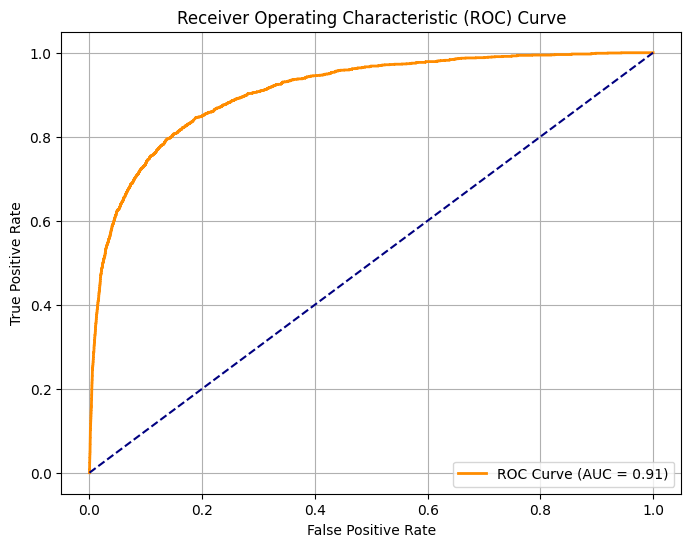

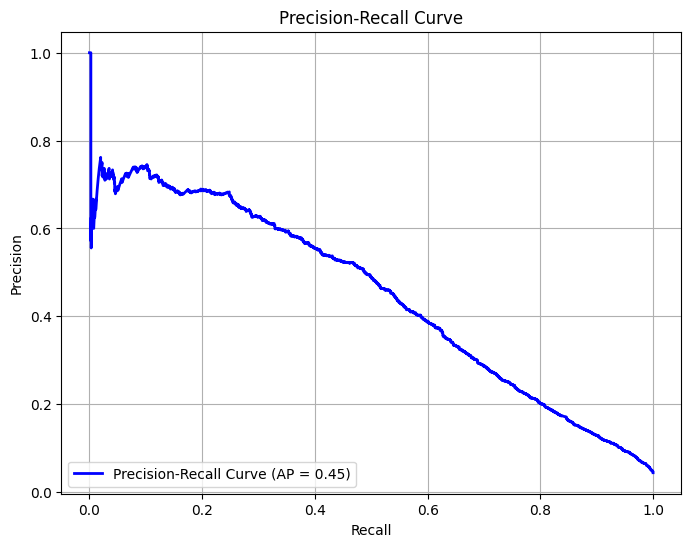

In [18]:
# Evaluate the model on the test data
loss, accuracy, roc_auc_metric, pr_auc_metric = model.evaluate([X_seq_test, X_num_test], y_test)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')
print(f'Test ROC AUC (from model.evaluate): {roc_auc_metric}')
print(f'Test PR AUC (from model.evaluate): {pr_auc_metric}')

# Obtain predicted probabilities
y_pred_proba = model.predict([X_seq_test, X_num_test]).ravel()

# Compute ROC AUC and PR AUC using scikit-learn


roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print(f'ROC AUC Score (from sklearn): {roc_auc:.4f}')
print(f'PR AUC Score (Average Precision from sklearn): {pr_auc:.4f}')

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {pr_auc:.2f})', color='blue', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
